<a href="https://colab.research.google.com/github/s331440/DAVE3625/blob/main/3D_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense , Reshape,Flatten,Conv3D,Conv3DTranspose,LeakyReLU,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.python import metrics
from tensorflow.keras.metrics import binary_crossentropy,categorical_crossentropy,sparse_categorical_crossentropy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = ('/content/drive/MyDrive/modelnet10.npz')

In [4]:
data = np.load(path, allow_pickle=True)
train_voxel = data["train_voxel"] # Training 3D voxel samples
test_voxel = data["test_voxel"] # Test 3D voxel samples
train_labels = data["train_labels"] # Training labels (integers from 0 to 9)
test_labels = data["test_labels"] # Test labels (integers from 0 to 9)
class_map = data["class_map"] # Dictionary mapping the labels to their class names.

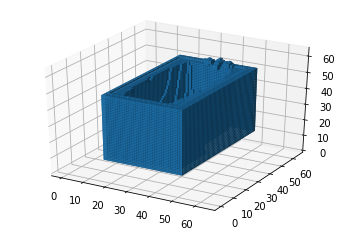

In [11]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(train_voxel[0])

plt.show()

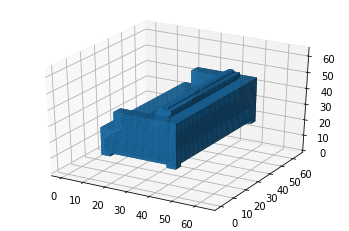

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(train_voxel[3000])

plt.show()

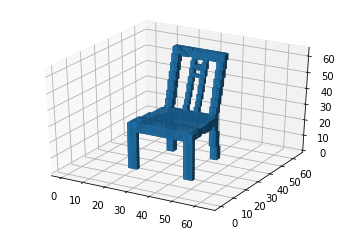

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(train_voxel[1500])

plt.show()

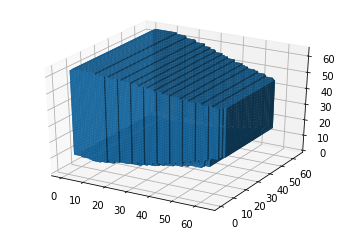

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(train_voxel[2000])

plt.show()

In [6]:
print(train_voxel.shape)

(3991, 64, 64, 64)


In [5]:
opt = Adam(learning_rate=0.0002,beta_1 = 0.5)

In [7]:
def define_discriminator(in_shape=(64,64,64,1)):
  print('inside discriminator')
  model = Sequential()
  model.add(Conv3D(64,(4,4,4), strides=(2,2,2), padding ='same', input_shape = in_shape))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(64,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(128,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(256,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(512,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())

  #model.add(Conv3D(512,(4,4,4), strides=(2,2,2), padding ='same'))
  #model.add(LeakyReLU(alpha= 0.00001))
  #model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dropout(0.4))
  ##assert model.output_shape == (None,4096)
  model.add(Dense(64,activation='sigmoid'))
  model.add(Dense(1,activation='sigmoid'))
  #model.add(Reshape(32,32,32))
  model.compile(loss=binary_crossentropy,optimizer=opt, metrics=['accuracy'])
  return model

In [8]:
test_discr = define_discriminator()
print(test_discr.summary())

inside discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 32, 32, 64)    4160      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32, 64)    0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 16, 16, 64)    262208    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 16, 64)    0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 16, 64)   256       
 hNormalization)                   

In [65]:
def define_generator(latent_dim):
  model = Sequential()
  n_nodes = 200*1*1*1
  model.add(Dense(n_nodes,input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((1,1,1,200)))
  model.add(Conv3DTranspose(512,(4,4,4), strides=(1,1,1),padding='valid'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(256,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(128,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(128,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(64,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Conv3DTranspose(128,(4,4,4), strides=(2,2,2),padding='same'))
  #model.add(BatchNormalization())
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3D(1,(8,8,8),activation = 'sigmoid',padding = 'same'))
  return model


In [66]:
test_gen = define_generator(200)
print(test_gen.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 200)               0         
                                                                 
 reshape_8 (Reshape)         (None, 1, 1, 1, 200)      0         
                                                                 
 conv3d_transpose_40 (Conv3D  (None, 4, 4, 4, 512)     6554112   
 Transpose)                                                      
                                                                 
 batch_normalization_50 (Bat  (None, 4, 4, 4, 512)     2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 4, 4, 4, 512)    

In [12]:
def generate_latent_points(latent_dim,n_samples):
  X_input = np.random.randn(latent_dim * n_samples)
  X_input = X_input.reshape(n_samples,latent_dim)
  return X_input  

In [13]:
def define_gan(generator,discriminator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = Adam(learning_rate = 0.0025,beta_1 = 0.5)
  model.compile(loss='binary_crossentropy',optimizer = opt)
  return model

In [14]:
def get_real_samples(train_voxel,n_samples):
  #choose random images
  ix = np.random.randint(0,train_voxel.shape[0],n_samples)
  X = train_voxel[ix]
  #assigning 1 to y indicating real images
  y = np.ones((n_samples,1))
  return X,y

In [15]:
def generate_fake_Samples(generator,latent_dim,n_samples):
  #generate points in latent space
  x_input = generate_latent_points(latent_dim,n_samples)
  #predict using generator to generate fake samples
  X = generator.predict(x_input)
  # labeled as 0 since they are fake samples
  y = np.zeros((n_samples,1))
  return X,y


In [ ]:
test_gen = define_generator(200)

print(test_gen.summary())

def generate_latent_points(latent_dim,n_samples):
  X_input = np.random.randn(latent_dim * n_samples)
  X_input = X_input.reshape(n_samples,latent_dim)
  return X_input

latent_dim = 200
n_samples = 10

X_out = generate_latent_points(latent_dim,n_samples)
print(X_out)

def define_gan(generator,discriminator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = Adam(learning_rate = 0.0025,beta_1 = 0.5)
  model.compile(loss='binary_crossentropy',optimizer = opt)
  return model

def get_real_samples(train_voxel,n_samples):
  #choose random images
  ix = np.random.randint(0,train_voxel.shape[0],n_samples)
  X = train_voxel[ix]
  #assigning 1 to y indicating real images
  y = np.ones((n_samples,1))
  return X,y

def generate_fake_Samples(generator,latent_dim,n_samples):
  #generate points in latent space
  x_input = generate_latent_points(latent_dim,n_samples)
  #predict using generator to generate fake samples
  X = generator.predict(x_input)
  # labeled as 0 since they are fake samples
  y = np.zeros((n_samples,1))
  return X,y

In [50]:
D_L_LOSS = []
G_L_LOSS = []

In [93]:
def train(g_model, d_model,gan_model,train_voxel,latent_dim,n_epochs = 3, n_batch= 10):
  bat_per_epo = int(train_voxel.shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  #training loop
  for i in range(n_epochs):
    for j in range(n_batch):
      
      X_real,y_real = get_real_samples(train_voxel,half_batch)
      #measuring loss of discriminator
      d_loss_real,_ = d_model.train_on_batch(X_real,y_real) 

      #generate fake samples
      X_fake,y_fake = generate_fake_Samples(g_model,latent_dim,half_batch)
      d_loss_fake,_ = d_model.train_on_batch(X_fake,y_fake)

      #prepare latent points as input to the generator
      X_gan = generate_latent_points(latent_dim,n_batch)

      #generated samples are labeled as valid to fool the discriminator
      y_gan = np.ones((n_batch,1))

      #train generator with latent_dim and y as 1
      g_loss = gan_model.train_on_batch(X_gan,y_gan)

      print('Epoch>%d, Batch %d/%d,d1=%.3f,d2=%.3f,g=%.3f' %
            (i+1,j+1,bat_per_epo,d_loss_real,d_loss_fake,g_loss))
      


      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      noise = np.random.normal(0, 1, (n_batch, 100))

      # the generator wants the discriminator to label the generated samples
      # as valid (ones)
      valid_y = np.array([1] * 32)

      # Plot the progress
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (n_epochs, d_loss_real, d_loss_fake, g_loss))
            
      D_L_LOSS.append(d_loss_real)
      G_L_LOSS.append(g_loss)
  return D_L_LOSS,G_L_LOSS

In [94]:
#train the gan
#size of latent space
latent_dim = 200
#create the discriminator
discriminator = define_discriminator()
#create the generator
generator = define_generator(latent_dim)
#create gan
gan_model = define_gan(generator,discriminator)
#train model
D_L_LOSS,G_L_LOSS =train(generator,discriminator,gan_model,train_voxel,latent_dim,n_epochs=3)

inside discriminator
1/1 [==============================] - 0s 242ms/step
Epoch>1, Batch 1/399,d1=1.005,d2=0.033,g=4.507
3 [D loss: 1.004535, acc.: 0.03%] [G loss: 4.507268]
1/1 [==============================] - 0s 28ms/step
Epoch>1, Batch 2/399,d1=0.019,d2=0.204,g=5.343
3 [D loss: 0.018655, acc.: 0.20%] [G loss: 5.342516]
1/1 [==============================] - 0s 27ms/step
Epoch>1, Batch 3/399,d1=2.969,d2=0.018,g=4.308
3 [D loss: 2.968831, acc.: 0.02%] [G loss: 4.308260]
1/1 [==============================] - 0s 40ms/step
Epoch>1, Batch 4/399,d1=0.018,d2=0.007,g=1.020
3 [D loss: 0.018089, acc.: 0.01%] [G loss: 1.019590]
1/1 [==============================] - 0s 28ms/step
Epoch>1, Batch 5/399,d1=0.011,d2=0.009,g=0.053
3 [D loss: 0.011461, acc.: 0.01%] [G loss: 0.053043]
1/1 [==============================] - 0s 28ms/step
Epoch>1, Batch 6/399,d1=0.010,d2=0.657,g=0.073
3 [D loss: 0.010407, acc.: 0.66%] [G loss: 0.072775]
1/1 [==============================] - 0s 28ms/step
Epoch>1, Batch

In [95]:
import os.path
discriminator.save('/content/drive/MyDrive/3D-discriminator.h5')

In [19]:
generator.save('/content/drive/MyDrive/3D-generator.h5')

In [20]:
from tensorflow.keras.models import load_model
temp = load_model('/content/drive/MyDrive/3D-discriminator.h5')

In [73]:
import tensorflow as tf

def create_model_classifier():
    inputs = tf.keras.Input(shape=(13,))
    x = tf.keras.layers.Dense(70, activation=tf.nn.relu)(inputs)
    outputs = tf.keras.layers.Dense(70, activation=tf.nn.relu)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [74]:
for i in range(len(test_gen)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(test_gen[label.numpy()[0]])
        plt.axis('off')

TypeError: ignored

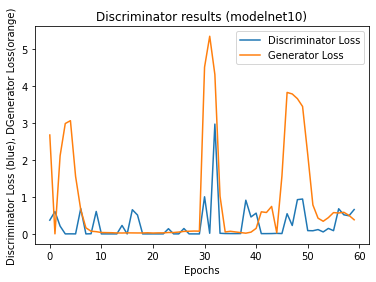

In [96]:

#this was used to try to show the history of the loss discriminator and generator

# loss values for further plotting
D_L_REAL = []
D_L_FAKE = []
D_L = []
D_ACC = []
G_L = []

plt.plot(D_L_LOSS)
plt.plot(G_L_LOSS)
plt.title('Discriminator results (modelnet10)')
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss (blue), DGenerator Loss(orange)')
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()


In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
temp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 32, 32, 32, 64)    4160      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 32, 64)    0         
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 16, 16, 16, 64)    262208    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 16, 64)    0         
                                                                 
 batch_normalization_11 (Bat  (None, 16, 16, 16, 64)   256       
 chNormalization)                                     

In [22]:
temp.get_weights()

[array([[[[[ 0.03597866,  0.00232694, -0.03239073, ...,  0.02423693,
             0.01454843,  0.00360476]],
 
          [[-0.01848885, -0.0175698 , -0.03161308, ..., -0.02198505,
            -0.03131494, -0.00611439]],
 
          [[-0.00605897, -0.01293381,  0.02537884, ...,  0.00521545,
            -0.0222984 , -0.00937555]],
 
          [[-0.01121312, -0.00448711,  0.02227298, ...,  0.02696464,
             0.01002337, -0.0285211 ]]],
 
 
         [[[ 0.02962208,  0.00185326,  0.01286832, ...,  0.03673139,
             0.03169174, -0.03383986]],
 
          [[ 0.03127263, -0.03545907, -0.03734231, ..., -0.01105877,
            -0.03215755, -0.00162768]],
 
          [[ 0.01992583, -0.03136137, -0.02024361, ..., -0.00680141,
             0.01954272,  0.00087242]],
 
          [[-0.02394638, -0.03335153, -0.02740743, ...,  0.0345617 ,
             0.00867778,  0.03373277]]],
 
 
         [[[ 0.02262143,  0.03024936,  0.00783327, ...,  0.02347944,
             0.00558024, -0.03060978]

In [23]:
temp.optimizer

In [24]:
layers = temp.layers
print(temp.inputs)
print(temp.layers[5])
print(temp.layers[8])
print(temp.layers[11])
#filters,biases = layers_classifier[1].get_weights()
#print(layers_classifier[1],filters.shape)

[<KerasTensor: shape=(None, 64, 64, 64, 1) dtype=float32 (created by layer 'conv3d_6_input')>]


In [25]:
from tensorflow.keras.layers import MaxPooling3D
opt = Adam(learning_rate=0.001)

In [26]:
def Classifier(temp):
  out1 = tf.keras.layers.MaxPool3D(pool_size=(8,8,8))(temp.layers[5].output)
  out2 = tf.keras.layers.MaxPool3D(pool_size=(4,4,4))(temp.layers[8].output)
  out3 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(temp.layers[11].output)
  conc = tf.keras.layers.Concatenate()([out1,out2,out3])
  flat = tf.keras.layers.Flatten()(conc)
  output = tf.keras.layers.Dense(10,activation='softmax')(flat)
  model = tf.keras.Model(inputs = temp.inputs,outputs = output)
  model.compile(loss=sparse_categorical_crossentropy,optimizer=opt, metrics=['accuracy'])
  return model

In [27]:
classifier = Classifier(temp)
print(classifier.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv3d_6_input (InputLayer)    [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_6 (Conv3D)              (None, 32, 32, 32,   4160        ['conv3d_6_input[0][0]']         
                                64)                                                               
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)     (None, 32, 32, 32,   0           ['conv3d_6[0][0]']               
                                64)                                                           

In [87]:
history = classifier.fit(x=train_voxel,batch_size=10,epochs=20,y=train_labels,shuffle=True)

Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.3260 - accuracy: 0.9088
Epoch 2/20
400/400 [==============================] - 3s 7ms/step - loss: 0.2936 - accuracy: 0.9158
Epoch 3/20
400/400 [==============================] - 3s 7ms/step - loss: 0.2640 - accuracy: 0.9266
Epoch 4/20
400/400 [==============================] - 3s 7ms/step - loss: 0.2338 - accuracy: 0.9344
Epoch 5/20
400/400 [==============================] - 3s 7ms/step - loss: 0.2236 - accuracy: 0.9359
Epoch 6/20
400/400 [==============================] - 3s 7ms/step - loss: 0.2120 - accuracy: 0.9331
Epoch 7/20
400/400 [==============================] - 3s 7ms/step - loss: 0.1939 - accuracy: 0.9509
Epoch 8/20
400/400 [==============================] - 3s 7ms/step - loss: 0.1762 - accuracy: 0.9496
Epoch 9/20
400/400 [==============================] - 3s 7ms/step - loss: 0.1700 - accuracy: 0.9551
Epoch 10/20
400/400 [==============================] - 3s 7ms/step - loss: 0.1604 - accuracy: 0.9539

In [88]:
acc = history.history['accuracy']

In [89]:
loss = history.history['loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

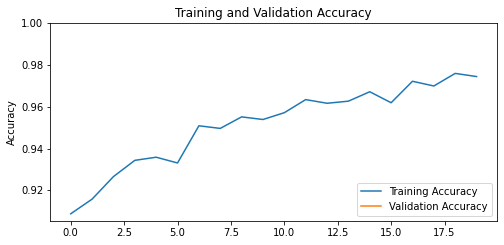

In [90]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

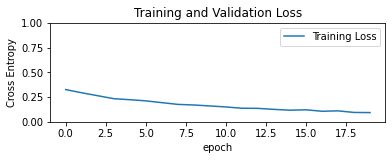

In [91]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()